In [3]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
fontpath = expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [57]:
from helpers import jaccard, populate_bin_with_channel, add_user_to_bin, bins_y_o, bins_t_o, bin_to_df
from helpers import triple_bin_to_df, intersec_3, colors, _jaccard, bins_y_s, bins_t_s
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
from sqlitedict import SqliteDict
import itertools
import numpy as np
import pandas as pd

def get_color_overlap(x):
    if x < 0.1:
        return "#FFFFFF"
    if x < 0.2:
        return "#DCDCDC"
    if x < 0.3:
        return "#A9A9A9"
    if x < 0.5:
        return "#696969"
    if x < 0.75:
        return "#2F4F4F"
    return "#222222"

def populate_bin_with_channel(channel, channel_dict, bin_dict):
    if channel in channel_dict:
        for user in channel_dict[channel]:
            add_user_to_bin(bin_dict, user["author"], user["timestamp"]*1000)

In [18]:
channel_dict = SqliteDict("/data/incels_helpers/channel_dict.sqlite", tablename="channels")
authors_dict = SqliteDict("/data/incels_helpers/authors_dict.sqlite", tablename="authors")
df_labels = pd.read_csv("./labels.csv")
cats = ["pua", "incels", "trp", "health", "mgtow", "mra"]

In [19]:
bins = {cat:{b:set() for b in bins_y_o} for cat in cats}

for cat, bin_dict in bins.items():
    for channel in df_labels.loc[df_labels["category"] == cat, "subreddits"]:
        populate_bin_with_channel(channel, channel_dict, bin_dict)

In [7]:
bins_shift = {cat:{b:set() for b in bins_y_o} for cat in cats}

for cat in cats:
    bin_dict = bins[cat]
    bin_sl_dict = bins_shift[cat]
    for idx in range(len(bins_y_o) - 1):
        shifted = sorted(bin_dict.keys())[idx+1]
        actual = sorted(bin_dict.keys())[idx]
        bin_sl_dict[shifted] = bin_dict[actual]

In [8]:
combs = list(itertools.combinations(cats,2))
bins_combs = {comb : bin_to_df(bins_y_o, bins[comb[0]], bins[comb[1]], jaccard) for comb in combs}
bins_sl = {cat : bin_to_df(bins_y_o, bins[cat], bins_shift[cat], jaccard) for cat in cats}

In [58]:
df_list = []
for t, df in bins_combs.items():
    df["kind"] = "-".join(sorted(t))
    df["idx_str"] = [v[-2:] for v in bins_t_o]
    df["overlapx"] = df["intersection"] / df["x"]
    df["overlapx"] = df["overlapx"].fillna(0)
    df["coloroverlapx"] = df["overlapx"].apply(get_color_overlap)
    df["overlapy"] = df["intersection"] / df["y"]
    df["overlapy"] = df["overlapy"].fillna(0)
    df["coloroverlapy"] = df["overlapy"].apply(get_color_overlap)
    df_list.append(df)

for t, df in bins_sl.items():
    df["kind"] = t + "-" + t
    df["xpct"] = df["x"] / df.sum().x
    df["idx_str"] = [v[-2:] for v in bins_t_o]
    df["overlapx"] = df["intersection"] / df["x"]
    df["overlapx"] = df["overlapx"].fillna(0)
    df["coloroverlapx"] = df["overlapx"].apply(get_color_overlap)
    df["overlapy"] = df["intersection"] / df["y"]
    df["overlapy"] = df["overlapy"].fillna(0)
    df["coloroverlapy"] = df["overlapy"].apply(get_color_overlap)
    
    df_list.append(df)
df_all = pd.concat(df_list)


/home/manoel/miniconda3/envs/rad/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [61]:
df_all[df_all.kind == "incels-incels"]

,coloroverlapx,coloroverlapy,idx,idx_str,intersection,jaccard,kind,overlapx,overlapy,x,x-y,xpct,y,y-x
0,#FFFFFF,#FFFFFF,"(1209556800000, 1241092800000)",08,0,0.000000,incels-incels,0.000000,0.000000,0,0,0.000000,0,0
1,#FFFFFF,#FFFFFF,"(1241092800000, 1272628800000)",09,0,0.000000,incels-incels,0.000000,0.000000,0,0,0.000000,0,0
2,#FFFFFF,#FFFFFF,"(1272628800000, 1304164800000)",10,0,0.000000,incels-incels,0.000000,0.000000,1367,1367,0.006414,0,0
3,#FFFFFF,#696969,"(1304164800000, 1335787200000)",11,565,0.039480,incels-incels,0.041824,0.413314,13509,12944,0.063389,1367,802
4,#DCDCDC,#A9A9A9,"(1335787200000, 1367323200000)",12,2858,0.106092,incels-incels,0.175467,0.211563,16288,13430,0.076429,13509,10651
5,#A9A9A9,#DCDCDC,"(1367323200000, 1398859200000)",13,2957,0.112996,incels-incels,0.230332,0.181545,12838,9881,0.060240,16288,13331
6,#A9A9A9,#A9A9A9,"(1398859200000, 1430395200000)",14,2842,0.127250,incels-incels,0.230345,0.221374,12338,9496,0.057894,12838,9996
7,#A9A9A9,#A9A9A9,"(1430395200000, 1462017600000)",15,3040,0.138566,incels-incels,0.240487,0.246393,12641,9601,0.059316,12338,9298
8,#DCDCDC,#A9A9A9,"(1462017600000, 1493553600000)",16,3572,0.092477,incels-incels,0.120851,0.282573,29557,25985,0.138691,12641,9069
9,#DCDCDC,#A9A9A9,"(1493553600000, 1525089600000)",17,6577,0.091361,incels-incels,0.134200,0.222519,49009,42432,0.229966,29557,22980


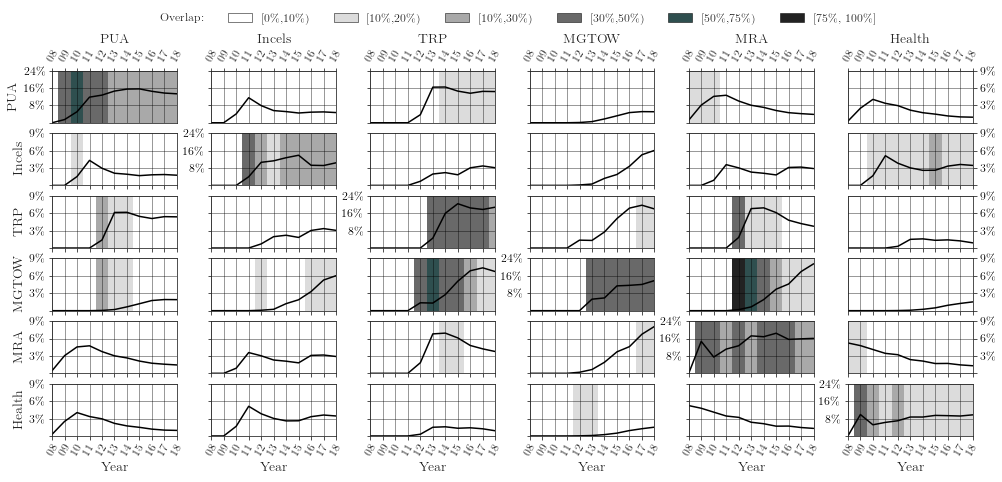

In [60]:
import matplotlib.patches as patches
import matplotlib.dates as matdates
from matplotlib.lines import Line2D

fig, axs = plt.subplots(6, 6, figsize=(16.5,7))
fig.subplots_adjust(wspace=0.275, top=0.85)

order = {0:"pua", 1:"incels", 2:"trp", 3:"mgtow", 4:"mra", 5:"health"}
correct_names = {"pua":"PUA", "incels":"Incels", "trp":"TRP", 
                 "mgtow":"MGTOW", "mra":"MRA", "health":"Health"}

for idx, idy in itertools.combinations_with_replacement(list(range(6)), 2):
    normx = axs[idy][idx]
    flipx = axs[idx][idy]
    df_tmp = df_all.loc[df_all.kind == "-".join(sorted([order[idx], order[idy]]))]

    sns.lineplot(x="idx_str",  y="jaccard", data=df_tmp, ax=normx, color="black")

    if idx != idy:
        sns.lineplot(x="idx_str",  y="jaccard", data=df_tmp, ax=flipx, color="black")        

    count = 0
    for _, row in df_tmp.iterrows():
        row = dict(row)
        if row["idx"][0] < 1209556800000:
            continue

        r1 = patches.Rectangle((count-0.5, 0), 1, 9, color=row["coloroverlapx"],  zorder=0)
        r2 = patches.Rectangle((count-0.5, 0), 1, 9, color=row["coloroverlapy"],  zorder=0)
        flipx.add_patch(r1)            
        normx.add_patch(r2) 
        count += 1
            
    for ax, flip in zip([normx, flipx], [False, True]):
    
        if idx == idy and flip:
            continue
        
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xlim([0,10])
        ax.xaxis.grid(color="#000000", linestyle='solid', alpha=0.5)
        ax.yaxis.grid(color="#000000", linestyle='solid', alpha=0.5)
        ax.set_yticklabels([])
        ax.set_ylim([0,0.09])
        ax.set_yticks([0, 0.03, 0.06, 0.09])
        
        if idx == 0 and flip or (idx == 0 and idy == 0):
            ax.xaxis.tick_top()

        elif idy != 5 or flip: 
            ax.set_xticklabels([])
            
        if idy == 5 and not flip:
            ax.set_xlabel("Year")


        if idx == 0 and (flip or idx==idy):
            ax.xaxis.set_label_position("top")
            ax.set_xlabel(correct_names[order[idy]])

        if idx == 0 and not flip:
            ax.set_yticks([0, 0.03, 0.06, 0.09])
            ax.set_yticklabels(["", "3\%", "6\%", "9\%"], color="black")
            ax.set_ylabel(correct_names[order[idy]])
        
        if idy == 5 and flip:
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            ax.set_yticks([0, 0.03, 0.06, 0.09])
            ax.set_yticklabels(["", "3\%", "6\%", "9\%"], color="black")

        if idx == idy:
            ax.yaxis.set_label_position("left")

            ax.set_ylim([0,0.24])
            ax.set_yticks([0, 0.08, 0.16, 0.24])
            ax.set_yticklabels(["", "8\%", "16\%", "24\%"], color="black")
            
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
            
custom_lines = [
patches.Rectangle((0,0),0.1,0.1,facecolor='#FFFFFF'),
patches.Rectangle((0,0),1,1,facecolor='#FFFFFF', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#DCDCDC', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#A9A9A9', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#696969', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#2F4F4F', edgecolor="#000000", lw=0.5),
patches.Rectangle((0,0),1,1,facecolor='#222222', edgecolor="#000000", lw=0.5)
]

axs[0][2].legend(custom_lines, ['Overlap:', '[0\%,10\\%)', '[10\%,20\\%)', '[10\%,30\%)', 
                                '[30\%,50\%)', '[50\%,75\%)', '[75\%, 100\%]'], 
          loc="center", ncol=7, bbox_to_anchor=(1.05, 2), frameon=False, fontsize=12)

fig.savefig("user_inter_reddit.pdf", bbox_inches='tight')
fig.savefig("user_inter_reddit.png", bbox_inches='tight')